# **Predicting Food Delivery Time Using Machine Learning**

**Objective**

To develop and evaluate an ETA prediction model that improves delivery time estimation accuracy and provides actionable insights to support operational decisions

## **Import Library**

In [ ]:
!pip install optuna
!pip install dalex
!pip install scikit-plot
!pip install shap
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.2-py3-none-any.whl size=1042898 sha256=45a76f0f4c3c8216be2adae6248b6db494761d4b46856f2fd3c21325c1f96c5f
  Stored in directory: /root/.cache/pip/wheels/17/0a/3a/8c988bdca6acd7ce4aa949726b26c382ad1635e065bf83a175
Successfully built dalex
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c6ad410519dc9059682edd164cfddd62b62f792eb96db05c5beee5286b7f88dc
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import dalex as dx
import shap
from lime.lime_tabular import LimeTabularExplainer
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Set the maximum number of columns and rows to display to a large number
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

## **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TUGAS/Take Home Test_DS/Food_Delivery_Times.csv')

In [ ]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


**Order_ID:** Unique identifier for each order.

**Distance_km:** The delivery distance in kilometers.

**Weather:** Weather conditions during the delivery, including Clear, Rainy, Snowy, Foggy, and Windy.

**Traffic_Level:** Traffic conditions categorized as Low, Medium, or High.

**Time_of_Day:** The time when the delivery took place, categorized as Morning, Afternoon, Evening, or Night.

**Vehicle_Type:** Type of vehicle used for delivery, including Bike, Scooter, and Car.

**Preparation_Time_min:** The time required to prepare the order, measured in minutes.

**Courier_Experience_yrs:** Experience of the courier in years.

**Delivery_Time_min:** The total delivery time in minutes (target variable).

## **Exploratory Data Analysis**

In [ ]:
#copy dataset untuk EDA

df_eda = df.copy()

In [ ]:
#cek duplicate

df_eda.duplicated().sum()

np.int64(0)

Tidak ada Duplicate Data

In [ ]:
#cek missing Value

df_eda.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,30
Traffic_Level,30
Time_of_Day,30
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,30
Delivery_Time_min,0


Terdapat Missing Value pada kolom Weather, traffic_level, Time_of_Day, dan Courier_Experience_yrs.

In [ ]:
#handling missing value kolom kategorik dengan modus

df_eda['Weather'] = df_eda['Weather'].fillna(df_eda['Weather'].mode()[0])
df_eda['Traffic_Level'] = df_eda['Traffic_Level'].fillna(df_eda['Traffic_Level'].mode()[0])
df_eda['Time_of_Day'] = df_eda['Time_of_Day'].fillna(df_eda['Time_of_Day'].mode()[0])

In [ ]:
#handling missing value courier experience dengan KNN inputer

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights="distance")
df_eda['Courier_Experience_yrs'] = imputer.fit_transform(df_eda[['Courier_Experience_yrs']])

#dibulatkan
df_eda['Courier_Experience_yrs'] = df_eda['Courier_Experience_yrs'].round().astype('int64')

In [ ]:
#cek missing value
df_eda.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,0
Traffic_Level,0
Time_of_Day,0
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,0
Delivery_Time_min,0


In [ ]:
df_eda.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.592000,56.732000
std,288.819436,5.696656,7.204553,2.871198,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [ ]:
df_eda.describe(include='object')

,Weather,Traffic_Level,Time_of_Day,Vehicle_Type
count,1000,1000,1000,1000
unique,5,3,4,3
top,Clear,Medium,Morning,Bike
freq,500,420,338,503


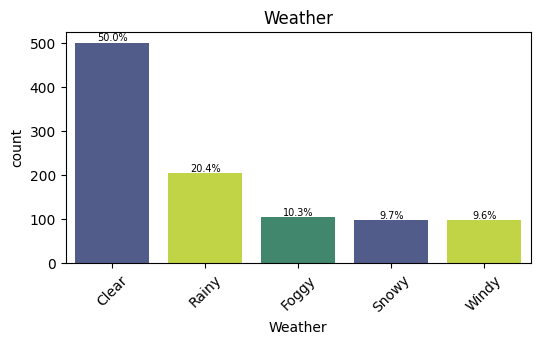

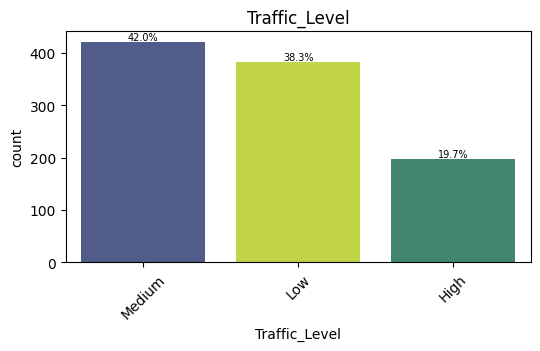

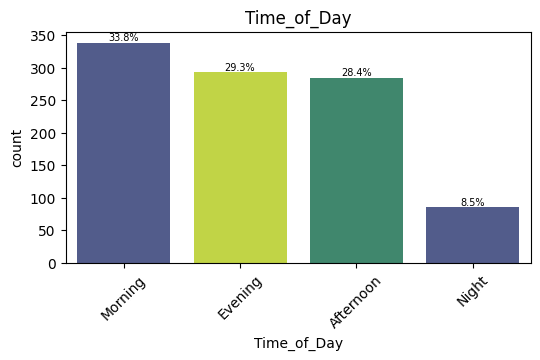

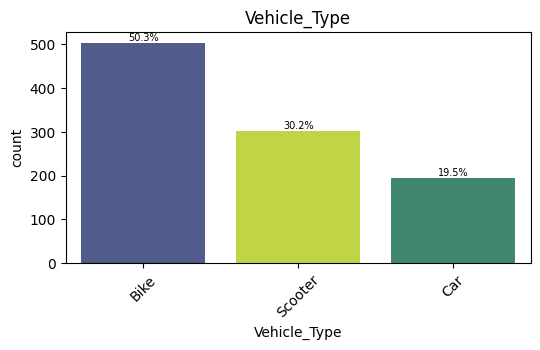

In [ ]:
kolom_kategorik = df_eda.select_dtypes(include=['object']).columns
palette = ['#485695', '#d2ec2e', '#349370']
for col in kolom_kategorik:
    plt.figure(figsize=(6,3))
    #mengurutkan kategori berdasarkan presentase
    order = df_eda[col].value_counts().index

    ax = sns.countplot(x=df_eda[col],order=order, palette= palette)
    plt.title(f'{col}')
    plt.xticks(rotation=45)

    total = len(df_eda)

    for p in ax.patches:
        percent = 100 * p.get_height() / total
        ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=7, color='black')
    plt.show()

Kruskal-Wallis test for Weather:
p = 0.000


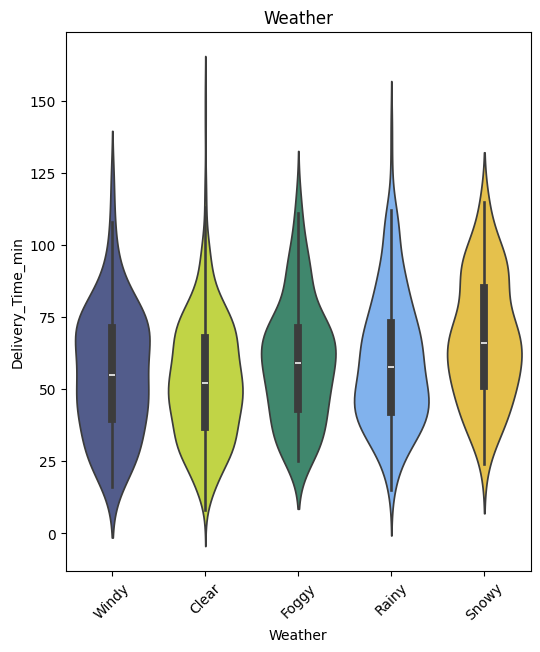

Kruskal-Wallis test for Traffic_Level:
p = 0.000


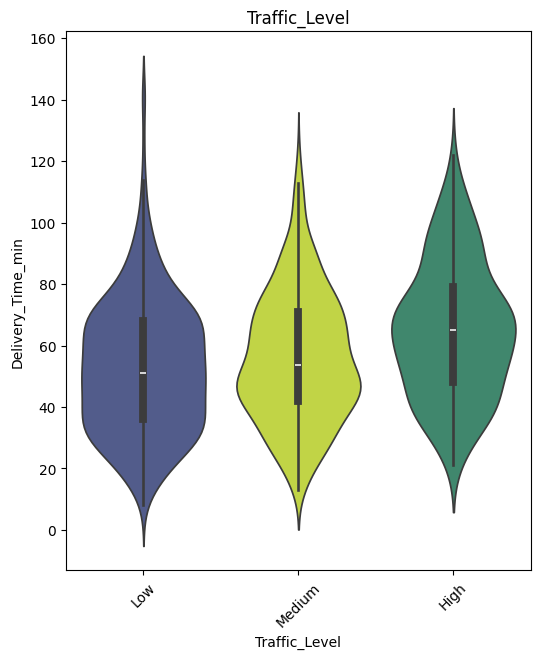

Kruskal-Wallis test for Time_of_Day:
p = 0.816


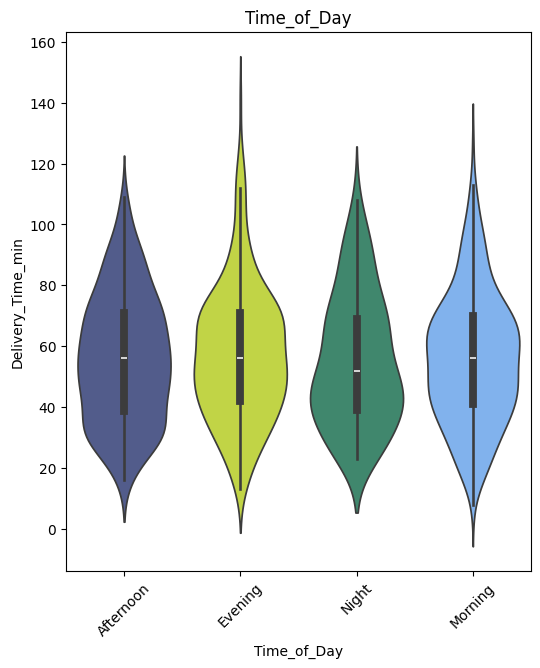

Kruskal-Wallis test for Vehicle_Type:
p = 0.611


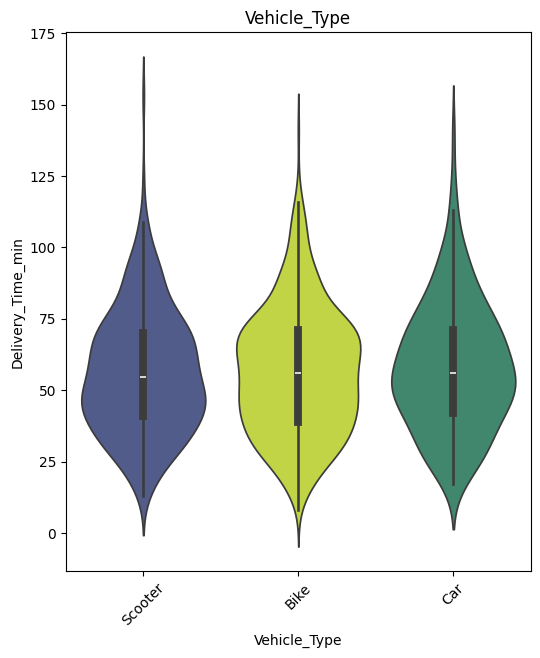

In [ ]:
#Violin plot delivery time
from scipy.stats import kruskal

kolom_kategorik = df_eda.select_dtypes(include=['object']).columns
palette = palette = ['#485695', '#d2ec2e', '#349370', '#6fb0ff', '#ffce32', '#ffa99a']
for col in kolom_kategorik:

  stat, p = kruskal(*df_eda.groupby(col)['Delivery_Time_min'].apply(list))
  print(f"Kruskal-Wallis test for {col}:")
  print(f"p = {p:.3f}")

  plt.figure(figsize=(6,7))
  sns.violinplot(x=df[col], y=df_eda['Delivery_Time_min'], palette=palette)
  plt.title(f'{col}')
  plt.xticks(rotation=45)
  plt.show()

Hasil uji Kruskal–Wallis menunjukkan bahwa Weather dan Traffic_Level memiliki perbedaan delivery time yang signifikan antar kategori (p = 0.000 → artinya p < 0.001). Dengan kata lain, waktu pengantaran memang berubah tergantung kondisi cuaca dan tingkat kemacetan.

Sebaliknya, Time_of_Day (p = 0.816) dan Vehicle_Type (p = 0.611) tidak menunjukkan perbedaan delivery time yang signifikan antar kategorinya. Artinya, dalam data ini, perbedaan waktu pengantaran berdasarkan waktu dalam sehari atau jenis kendaraan cenderung kecil/tidak konsisten, sehingga kolom ini sebaiknya di drop saat modelling karena tidak memberikan pengaruh.

## **Split Train and Test**

In [ ]:
#split train dan test

df_pretrain, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
df_pretrain.shape

(800, 9)

In [ ]:
df_test.shape

(200, 9)

## **Data Cleaning for Machine Learning**

### **Handling Missing Value**

In [ ]:
#handling missing value kolom kategorik dengan modus di train

df_pretrain['Weather'] = df_pretrain['Weather'].fillna(df_pretrain['Weather'].mode()[0])
df_pretrain['Traffic_Level'] = df_pretrain['Traffic_Level'].fillna(df_pretrain['Traffic_Level'].mode()[0])
df_pretrain['Time_of_Day'] = df_pretrain['Time_of_Day'].fillna(df_pretrain['Time_of_Day'].mode()[0])

In [ ]:
#handling missing value di test

df_test['Weather'] = df_test['Weather'].fillna(df_pretrain['Weather'].mode()[0])
df_test['Traffic_Level'] = df_test['Traffic_Level'].fillna(df_pretrain['Traffic_Level'].mode()[0])
df_test['Time_of_Day'] = df_test['Time_of_Day'].fillna(df_pretrain['Time_of_Day'].mode()[0])

In [ ]:
#handling missing value kolom numerik menggunakan KNNimputer di data train

imputer = KNNImputer(n_neighbors=5, weights="distance")
df_pretrain['Courier_Experience_yrs'] = imputer.fit_transform(df_pretrain[['Courier_Experience_yrs']])

#dibulatkan
df_pretrain['Courier_Experience_yrs'] = df_pretrain['Courier_Experience_yrs'].round().astype('int64')

In [ ]:
#handling missing value kolom numerik menggunakan KNNimputer di data test

df_test[['Courier_Experience_yrs']] = imputer.transform(df_test[['Courier_Experience_yrs']])

#dibulatkan
df_test['Courier_Experience_yrs'] = df_test['Courier_Experience_yrs'].round().astype('int64')

In [ ]:
#cek missing value di train

df_pretrain.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,0
Traffic_Level,0
Time_of_Day,0
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,0
Delivery_Time_min,0


In [ ]:
#cek missing value di test

df_test.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,0
Traffic_Level,0
Time_of_Day,0
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,0
Delivery_Time_min,0


### **Outlier Check**

In [ ]:
def check_plot(df_pretrain, variable):
    '''
      fungsi mengambil kerangka data (df) dan
      variabel yang diminati sebagai argumen
    '''

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df_pretrain[variable], bins=30, kde=True)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df_pretrain[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df_pretrain[variable])
    plt.title('Boxplot')

    plt.show()

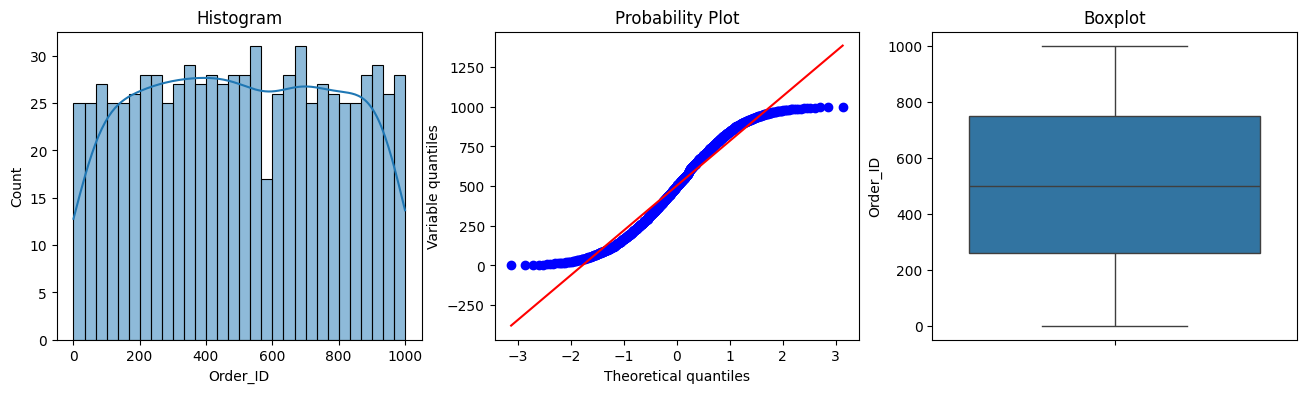

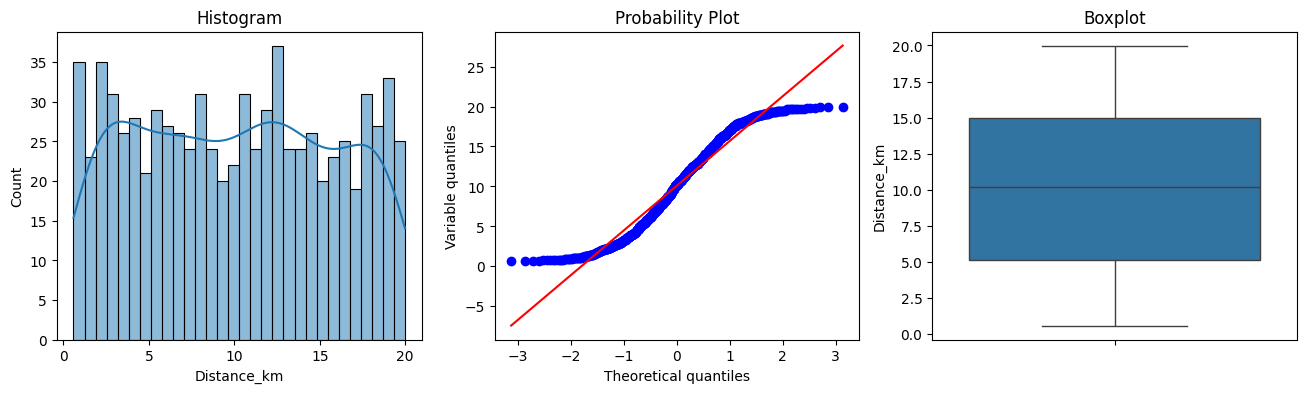

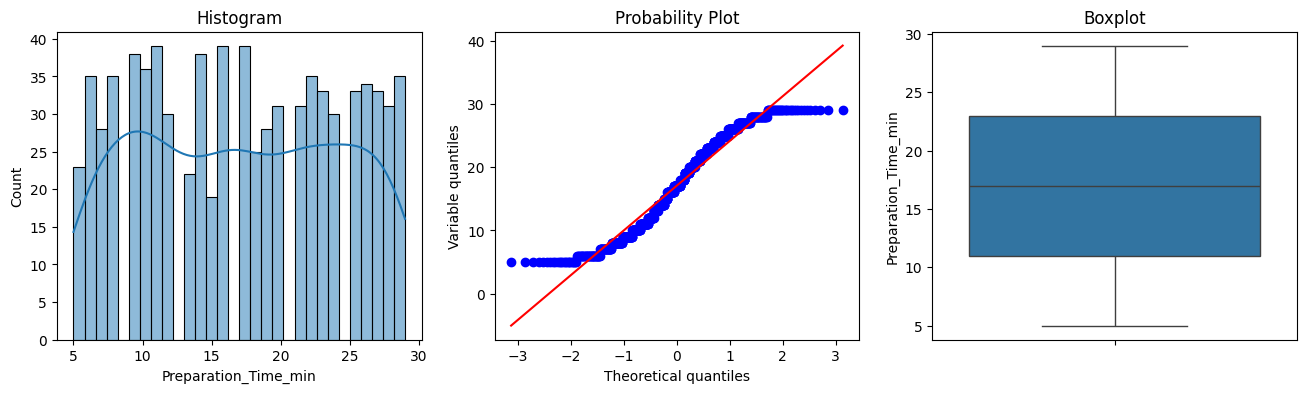

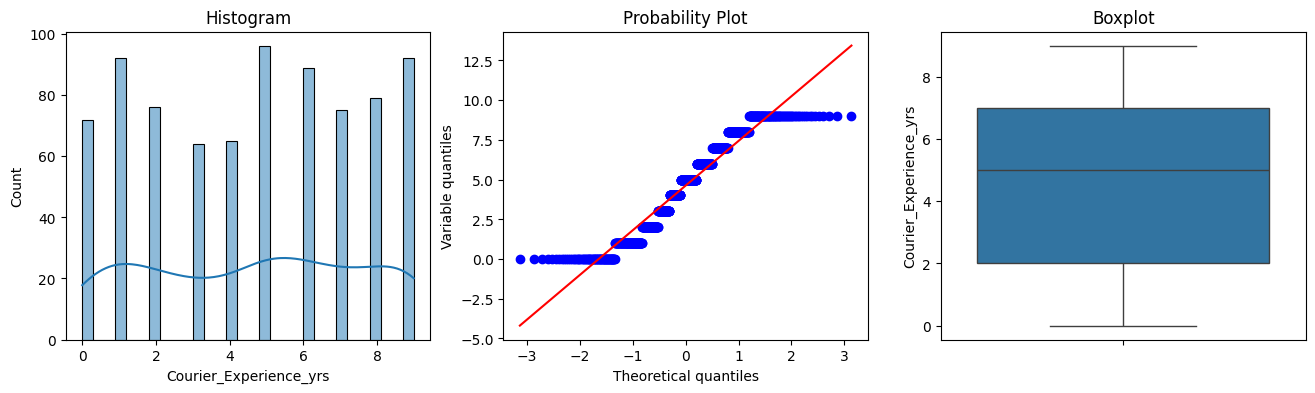

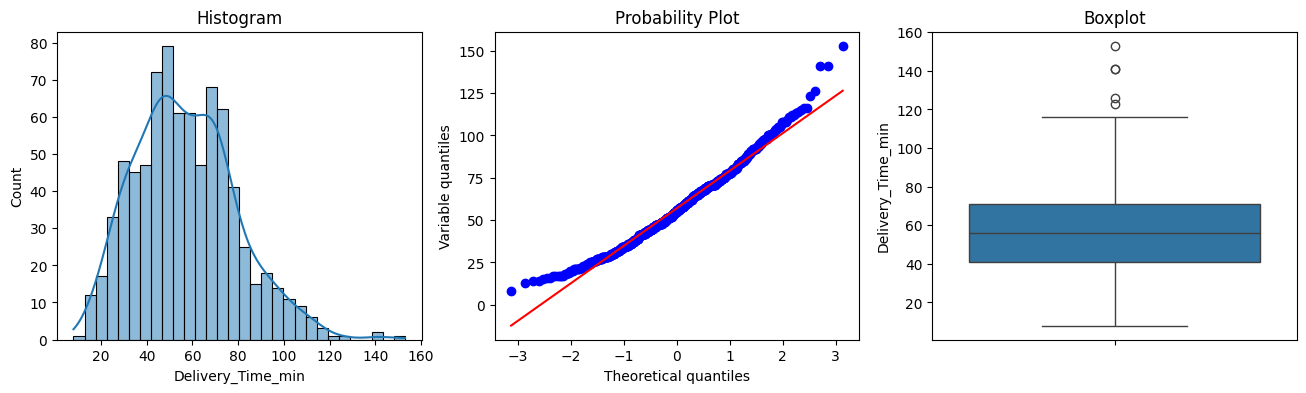

In [ ]:
import scipy.stats as stats

# visualisasikan outlier hanya pada kolom numerik
numeric_columns = df_pretrain.select_dtypes(include=['number']).columns
for col in numeric_columns:
    check_plot(df_pretrain, col)

tidak ada outlier

In [ ]:
#drop kolom id

df_pretrain = df_pretrain.drop('Order_ID', axis=1)
df_test = df_test.drop('Order_ID', axis=1)

<Axes: >

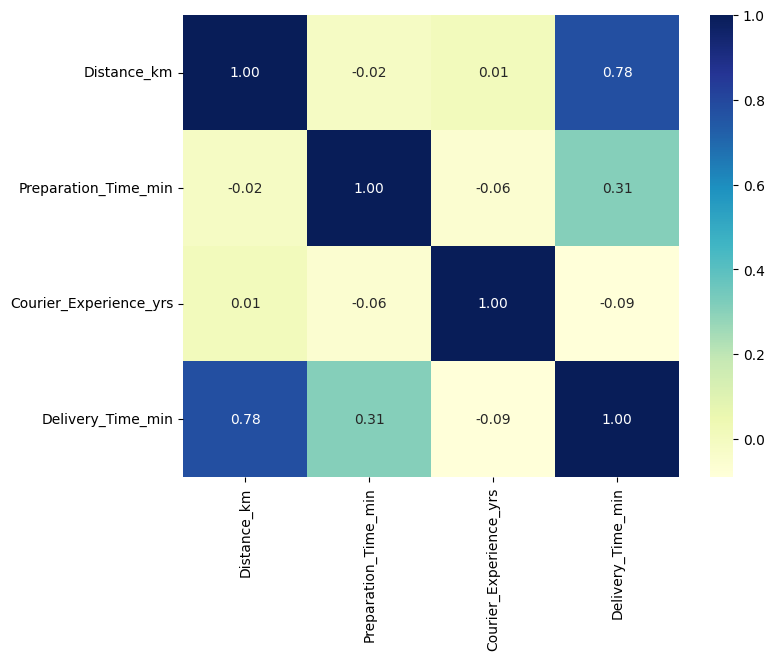

In [ ]:
numeric_columns = df_pretrain.select_dtypes(include=['int64', 'float64']).columns

# correlation heatmap
plt.figure(figsize=(8,6))
correlation = df_pretrain[numeric_columns].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='YlGnBu')

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

B = add_constant(df_pretrain.select_dtypes(include=['number']))

vif_df = pd.DataFrame([vif(B.values, i)for i in range(B.shape[1])], index=B.columns).reset_index()

vif_df.columns = ['Features', 'VIF']
vif_df = vif_df.loc[vif_df.Features != 'const']
vif_df

,Features,VIF
1,Distance_km,3.102276
2,Preparation_Time_min,1.345937
3,Courier_Experience_yrs,1.024961
4,Delivery_Time_min,3.442897


In [ ]:
'''
Berdasarkan uji kruskal wallis pada kolom kolom vehicle type dan times a day
tidak menujukkan perbedaan yang signifikan antar kategorinya
makan kolom tersebut akan di drop
'''

df_pretrain = df_pretrain.drop(['Vehicle_Type', 'Time_of_Day'], axis=1)
df_test = df_test.drop(['Vehicle_Type', 'Time_of_Day'], axis=1)

In [ ]:
#save as csv clean

## **Feature Scalling**

In [ ]:
#OHE Trafic Level dan Vehicle type

df_pretrain = pd.get_dummies(df_pretrain, columns=
 ['Traffic_Level', 'Weather'], drop_first=False,dtype=int)
df_test = pd.get_dummies(df_test, columns=
 ['Traffic_Level', 'Weather'],  drop_first=False,dtype=int)

In [ ]:
#Standard Scaller

scaler = StandardScaler()
columns_scale = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']
df_pretrain[columns_scale] = scaler.fit_transform(df_pretrain[columns_scale])
df_test[columns_scale] = scaler.transform(df_test[columns_scale])

In [ ]:
df_pretrain.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy
29,1.389200,-0.980721,0.820833,123,0,0,1,1,0,0,0,0
535,-1.391140,0.126852,-0.557994,34,1,0,0,1,0,0,0,0
695,-1.200658,-0.011595,1.510246,33,1,0,0,1,0,0,0,0
557,-0.452710,1.372871,0.476126,50,0,1,0,0,0,1,0,0
836,-0.957750,-1.257614,-0.557994,33,0,0,1,0,0,1,0,0


## **Split X_train dan y_train**

In [ ]:
# split data train

X_pretrain = df_pretrain.drop('Delivery_Time_min', axis=1)
y_pretrain = df_pretrain['Delivery_Time_min']

In [ ]:
# split data test

X_test = df_test.drop('Delivery_Time_min', axis=1)
y_test = df_test['Delivery_Time_min']

In [ ]:
#pisah train sama val

X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, test_size=0.2, random_state=42)

## **Modelling**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def objective(trial):
    lr_params = {
        "fit_intercept": True,
        "positive": trial.suggest_categorical("positive", [False, True]),
        "n_jobs": -1
    }

    model_lr = LinearRegression(**lr_params)
    model_lr.fit(X_train, y_train)

    pred = model_lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

best_params_lr = study.best_params
best_rmse_lr = study.best_value

print("Best params LR:", study.best_params)
print("Best val RMSE:", study.best_value)

[I 2025-12-28 15:10:19,646] A new study created in memory with name: no-name-24ad0703-6d14-472f-a59e-75bd1a6133d6
[I 2025-12-28 15:10:19,659] Trial 0 finished with value: 11.439356187427116 and parameters: {'positive': True}. Best is trial 0 with value: 11.439356187427116.
[I 2025-12-28 15:10:19,670] Trial 1 finished with value: 11.160659070666306 and parameters: {'positive': False}. Best is trial 1 with value: 11.160659070666306.
[I 2025-12-28 15:10:19,676] Trial 2 finished with value: 11.160659070666306 and parameters: {'positive': False}. Best is trial 1 with value: 11.160659070666306.
[I 2025-12-28 15:10:19,682] Trial 3 finished with value: 11.439356187427116 and parameters: {'positive': True}. Best is trial 1 with value: 11.160659070666306.
[I 2025-12-28 15:10:19,688] Trial 4 finished with value: 11.439356187427116 and parameters: {'positive': True}. Best is trial 1 with value: 11.160659070666306.
[I 2025-12-28 15:10:19,696] Trial 5 finished with value: 11.439356187427116 and para

Best params LR: {'positive': False}
Best val RMSE: 11.160659070666306


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def objective(trial):
    ridge_params = {
        "alpha": trial.suggest_float("alpha", 1e-4, 1e3, log=True),
        "fit_intercept": True,
        "solver": trial.suggest_categorical("solver", ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
        "random_state": 42,
    }

    model_ridge = Ridge(**ridge_params)
    model_ridge.fit(X_train, y_train)

    pred = model_ridge.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

best_params_ridge = study.best_params
best_rmse_ridge = study.best_value

print("Best params ridge:", study.best_params)
print("Best val RMSE:", study.best_value)

[I 2025-12-28 15:10:20,355] A new study created in memory with name: no-name-9309a4b0-0535-4e2a-931c-0429b1382c32
[I 2025-12-28 15:10:20,364] Trial 0 finished with value: 11.160520130912058 and parameters: {'alpha': 0.041858227295469716, 'solver': 'auto'}. Best is trial 0 with value: 11.160520130912058.
[I 2025-12-28 15:10:20,370] Trial 1 finished with value: 11.15569381738573 and parameters: {'alpha': 1.6136341713591311, 'solver': 'cholesky'}. Best is trial 1 with value: 11.15569381738573.
[I 2025-12-28 15:10:20,376] Trial 2 finished with value: 11.16030871041768 and parameters: {'alpha': 0.013480180290890806, 'solver': 'lsqr'}. Best is trial 1 with value: 11.15569381738573.
[I 2025-12-28 15:10:20,381] Trial 3 finished with value: 11.160144815720633 and parameters: {'alpha': 0.15577217702693022, 'solver': 'auto'}. Best is trial 1 with value: 11.15569381738573.
[I 2025-12-28 15:10:20,389] Trial 4 finished with value: 11.160658121666676 and parameters: {'alpha': 0.00028533901052402264, 

Best params ridge: {'alpha': 14.158489680265467, 'solver': 'lsqr'}
Best val RMSE: 11.139355873462126


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def objective(trial):
    lasso_params = {
        "alpha": trial.suggest_float("alpha", 1e-5, 1e1, log=True),
        "fit_intercept": True,
        "max_iter": 20000,
        "tol": trial.suggest_float("tol", 1e-6, 1e-3, log=True),
        "selection": trial.suggest_categorical("selection", ["cyclic", "random"]),
        "random_state": 42,   # dipakai kalau selection="random"
    }

    model_lasso = Lasso(**lasso_params)
    model_lasso.fit(X_train, y_train)   # pastikan X_train sudah OHE+Scaler untuk hasil terbaik

    pred = model_lasso.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

best_params_lasso = study.best_params
best_rmse_lasso = study.best_value

print("Best params lasso:", best_params_lasso)
print("Best val RMSE:", best_rmse_lasso)

[I 2025-12-28 15:10:21,426] A new study created in memory with name: no-name-5ce72709-7cfe-4adf-bb8c-8d66bf2648e1
[I 2025-12-28 15:10:21,433] Trial 0 finished with value: 11.160062445508945 and parameters: {'alpha': 0.0017670169402947942, 'tol': 0.0007114476009343421, 'selection': 'cyclic'}. Best is trial 0 with value: 11.160062445508945.
[I 2025-12-28 15:10:21,489] Trial 1 finished with value: 11.160650331640742 and parameters: {'alpha': 8.632008168602535e-05, 'tol': 2.9375384576328313e-06, 'selection': 'random'}. Best is trial 0 with value: 11.160062445508945.
[I 2025-12-28 15:10:21,498] Trial 2 finished with value: 11.149795335963205 and parameters: {'alpha': 0.040428727350273294, 'tol': 0.000133112160807369, 'selection': 'random'}. Best is trial 2 with value: 11.149795335963205.
[I 2025-12-28 15:10:21,504] Trial 3 finished with value: 11.721508163404804 and parameters: {'alpha': 0.9877700294007907, 'tol': 4.335281794951567e-06, 'selection': 'random'}. Best is trial 2 with value: 11

Best params lasso: {'alpha': 0.07731709822389364, 'tol': 8.728960545829835e-05, 'selection': 'random'}
Best val RMSE: 11.146383955243563


In [ ]:
from xgboost import XGBRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 20.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),

        "objective": "reg:squarederror",
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist",
    }

    model_xgb = XGBRegressor(**params)
    model_xgb.fit(X_train, y_train)

    #Validation
    pred = model_xgb.predict(X_val)

    # Calculate MSE first, then take the square root for RMSE
    mse = mean_squared_error(y_val, pred)
    rmse = np.sqrt(mse)
    return rmse

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

best_params_xgb = study.best_params
best_rmse_xgb = study.best_value

print("Best params xgb:", study.best_params)
print("Best val RMSE:", study.best_value)

[I 2025-12-28 15:10:22,828] A new study created in memory with name: no-name-2e769d7a-5bc9-4a41-8990-15332fa0b1e5
[I 2025-12-28 15:10:23,212] Trial 0 finished with value: 13.848945968677883 and parameters: {'n_estimators': 937, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 6.009974718380312, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 13.848945968677883.
[I 2025-12-28 15:10:24,026] Trial 1 finished with value: 12.203996497769824 and parameters: {'n_estimators': 1504, 'learning_rate': 0.010725209743171997, 'max_depth': 10, 'min_child_weight': 12.10689693600216, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 12.203996497769824.
[I 2025-12-28 15:10:24,504] T

Best params xgb: {'n_estimators': 347, 'learning_rate': 0.016228160878458985, 'max_depth': 4, 'min_child_weight': 3.803525136608833, 'subsample': 0.7438079667723431, 'colsample_bytree': 0.9050090291747632, 'gamma': 4.2147289697594, 'reg_alpha': 1.007490064677005e-08, 'reg_lambda': 1.9418186860521192}
Best val RMSE: 11.167293777696672


## **Model Evaluation**

In [ ]:
#model linear regression

lr = LinearRegression(**best_params_lr).fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test, y_pred_test)

print(f"R2 Train: {r2_train:.4f}")
print(f"R2 Test : {r2_test:.4f}")

R2 Train: 0.7651
R2 Test : 0.8236


In [ ]:
#prediksi

y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)

print(f"RMSE: {rmse:.3f} minutes")
print(f"MAE : {mae:.3f} minutes")
print(f"R2  : {r2:.3f}")

RMSE: 8.893 minutes
MAE : 6.066 minutes
R2  : 0.824


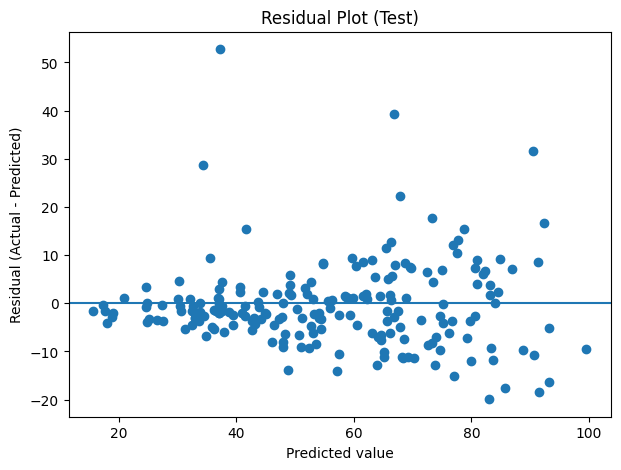

In [ ]:
df_resid = pd.DataFrame({
    "predicted_value": y_pred_test,
    "residual": y_test - y_pred_test
})

plt.figure(figsize=(7,5))
plt.scatter(df_resid["predicted_value"], df_resid["residual"])
plt.axhline(0)
plt.xlabel("Predicted value")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Test)")
plt.show()

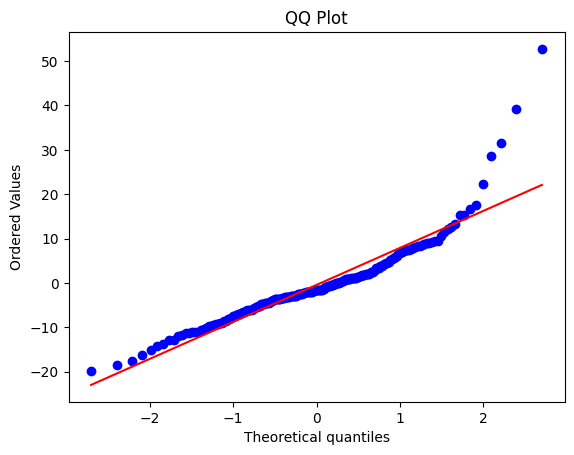

In [ ]:
#Plot normality qq plot

residuals = y_test - y_pred_test
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

In [ ]:
coef_df = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coefficient':[lr.intercept_] + list(lr.coef_)
})

coef_df

,feature,coefficient
0,intercept,60.018904
1,Distance_km,17.043634
2,Preparation_Time_min,7.329256
3,Courier_Experience_yrs,-1.796574
4,Traffic_Level_High,5.456520
5,Traffic_Level_Low,-5.241762
6,Traffic_Level_Medium,-0.214759
7,Weather_Clear,-4.558389
8,Weather_Foggy,1.391213
9,Weather_Rainy,-0.239651


Model memprediksi waktu pengantaran dengan baseline sekitar 60 menit (intercept), lalu waktu tersebut akan bertambah atau berkurang tergantung kondisi order. Faktor yang paling kuat memperpanjang delivery time adalah jarak (+17,0) dan waktu persiapan (+7,3). Kondisi operasional seperti macet tinggi (+5,4) dan cuaca bersalju (+5,7) juga memberi tambahan menit yang cukup besar. Sebaliknya, pengantaran cenderung lebih cepat saat lalu lintas rendah (−5,2) dan cuaca cerah (−4,5), serta ketika kurir lebih berpengalaman (−1,8 per tahun).

### **Ridge**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ridge_after = Ridge(**best_params_ridge).fit(X_train, y_train)

y_pred_train = ridge_after.predict(X_train)
y_pred_test  = ridge_after.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test, y_pred_test)

print(f"R2 Train: {r2_train:.4f}")
print(f"R2 Test : {r2_test:.4f}")

R2 Train: 0.7643
R2 Test : 0.8212


In [ ]:
#prediksi

y_pred = ridge_after.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)

print(f"RMSE: {rmse:.3f} minutes")
print(f"MAE : {mae:.3f} minutes")
print(f"R2  : {r2:.3f}")

RMSE: 8.952 minutes
MAE : 6.173 minutes
R2  : 0.821


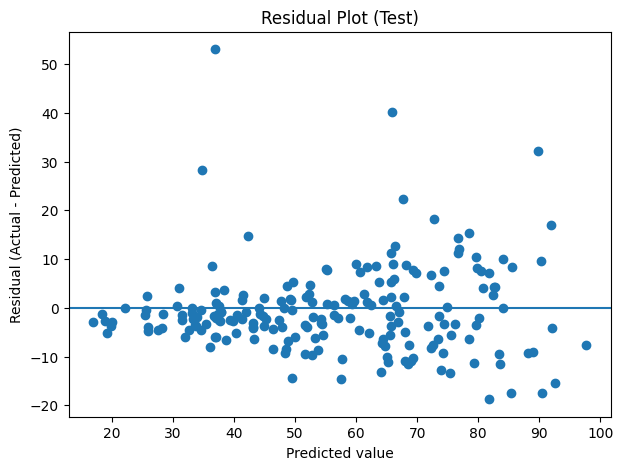

In [ ]:
df_resid = pd.DataFrame({
    "predicted_value": y_pred_test,
    "residual": y_test - y_pred_test
})

plt.figure(figsize=(7,5))
plt.scatter(df_resid["predicted_value"], df_resid["residual"])
plt.axhline(0)
plt.xlabel("Predicted value")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Test)")
plt.show()

In [ ]:
coef_df = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coefficient':[ridge_after.intercept_] + list(ridge_after.coef_)
})

coef_df

,feature,coefficient
0,intercept,59.761460
1,Distance_km,16.717137
2,Preparation_Time_min,7.154867
3,Courier_Experience_yrs,-1.776210
4,Traffic_Level_High,4.983511
5,Traffic_Level_Low,-4.819141
6,Traffic_Level_Medium,-0.164370
7,Weather_Clear,-4.221575
8,Weather_Foggy,1.194844
9,Weather_Rainy,-0.034689


### **Lasso**

In [ ]:
lasso_after = Lasso(**best_params_lasso).fit(X_train, y_train)

y_pred_train = lasso_after.predict(X_train)
y_pred_test  = lasso_after.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test, y_pred_test)

print(f"R2 Train: {r2_train:.4f}")
print(f"R2 Test : {r2_test:.4f}")

R2 Train: 0.7645
R2 Test : 0.8202


In [ ]:
#prediksi

y_pred = lasso_after.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)

print(f"RMSE: {rmse:.3f} minutes")
print(f"MAE : {mae:.3f} minutes")
print(f"R2  : {r2:.3f}")

RMSE: 8.977 minutes
MAE : 6.135 minutes
R2  : 0.820


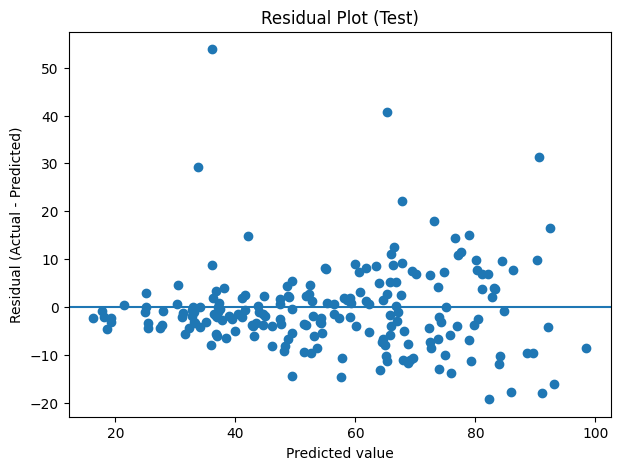

In [ ]:
df_resid = pd.DataFrame({
    "predicted_value": y_pred_test,
    "residual": y_test - y_pred_test
})

plt.figure(figsize=(7,5))
plt.scatter(df_resid["predicted_value"], df_resid["residual"])
plt.axhline(0)
plt.xlabel("Predicted value")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Test)")
plt.show()

In [ ]:
coef_df = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coefficient':[lasso_after.intercept_] + list(lasso_after.coef_)
})

coef_df

,feature,coefficient
0,intercept,59.532405
1,Distance_km,16.994077
2,Preparation_Time_min,7.241650
3,Courier_Experience_yrs,-1.752773
4,Traffic_Level_High,5.283803
5,Traffic_Level_Low,-4.724111
6,Traffic_Level_Medium,-0.000000
7,Weather_Clear,-4.181662
8,Weather_Foggy,0.790016
9,Weather_Rainy,-0.000000


### **XGBRegressor**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

xgb_after = XGBRegressor(**best_params_xgb).fit(X_train, y_train)

# setelah model.fit(X_train, y_train)
y_pred_train = xgb_after.predict(X_train)
y_pred_test  = xgb_after.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test, y_pred_test)

print(f"R2 Train: {r2_train:.4f}")
print(f"R2 Test : {r2_test:.4f}")

R2 Train: 0.8562
R2 Test : 0.8164


In [ ]:
# prediksi
y_pred = xgb_after.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)

print(f"RMSE: {rmse:.3f} minutes")
print(f"MAE : {mae:.3f} minutes")
print(f"R2  : {r2:.3f}")

RMSE: 9.072 minutes
MAE : 6.463 minutes
R2  : 0.816


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

t1, t2 = 41, 71

m1 = y_test <= t1
m2 = (y_test > t1) & (y_test <= t2)
m3 = y_test > t2

segments = [(f"<= {t1} min", m1), (f"{t1}-{t2} min", m2), (f"> {t2} min", m3)]

# Get predictions for linear, Ridge, Lasso, and XGBoost models on the test set
pred_lr = lr.predict(X_test)
pred_ridge = ridge_after.predict(X_test)
pred_lasso = lasso_after.predict(X_test)
pred_xgb = xgb_after.predict(X_test)

for name, m in segments:
    rmse_lr = np.sqrt(mean_squared_error(y_test[m], pred_lr[m]))
    mae_lr  = mean_absolute_error(y_test[m], pred_lr[m])

    rmse_ridge = np.sqrt(mean_squared_error(y_test[m], pred_ridge[m]))
    mae_ridge  = mean_absolute_error(y_test[m], pred_ridge[m])

    rmse_lasso = np.sqrt(mean_squared_error(y_test[m], pred_lasso[m]))
    mae_lasso  = mean_absolute_error(y_test[m], pred_lasso[m])

    rmse_xgb = np.sqrt(mean_squared_error(y_test[m], pred_xgb[m]))
    mae_xgb  = mean_absolute_error(y_test[m], pred_xgb[m])

    print(f"\nSEGMENT {name} (n={m.sum()})")
    print(f"Linear Regression -> RMSE: {rmse_lr:.3f} | MAE: {mae_lr:.3f}")
    print(f"Ridge -> RMSE: {rmse_ridge:.3f} | MAE: {mae_ridge:.3f}")
    print(f"Lasso -> RMSE: {rmse_lasso:.3f} | MAE: {mae_lasso:.3f}")
    print(f"XGB   -> RMSE: {rmse_xgb:.3f} | MAE: {mae_xgb:.3f}")


SEGMENT <= 41 min (n=59)
Linear Regression -> RMSE: 3.904 | MAE: 2.989
Ridge -> RMSE: 4.321 | MAE: 3.427
Lasso -> RMSE: 4.149 | MAE: 3.193
XGB   -> RMSE: 4.979 | MAE: 4.074

SEGMENT 41-71 min (n=94)
Linear Regression -> RMSE: 7.567 | MAE: 5.756
Ridge -> RMSE: 7.389 | MAE: 5.618
Lasso -> RMSE: 7.504 | MAE: 5.703
XGB   -> RMSE: 7.624 | MAE: 5.849

SEGMENT > 71 min (n=47)
Linear Regression -> RMSE: 14.244 | MAE: 10.549
Ridge -> RMSE: 14.436 | MAE: 10.728
Lasso -> RMSE: 14.446 | MAE: 10.693
XGB   -> RMSE: 14.243 | MAE: 10.687


Model Evaluation:
- Empat model diuji untuk memprediksi delivery time (menit): Linear Regression, Ridge, Lasso, dan XGBoost.
- Linear Regression menjadi model terbaik secara keseluruhan dengan performa test paling tinggi (R² Test = 0.8236) dan error paling rendah (RMSE = 8.893 menit; MAE = 6.066 menit).
- Ridge dan Lasso memberikan hasil yang sangat dekat, namun sedikit lebih buruk dibanding Linear Regression.
- XGBoost menunjukkan indikasi overfitting ringan karena R² Train (0.8562) jauh lebih tinggi daripada R² Test (0.8164), serta error test lebih besar.

Segment-Based Evaluation (IQR: 41–71 menit), dilakukan karena terjadi heteroskedastisitas
- Evaluasi juga dilakukan per segmen berdasarkan IQR untuk memastikan performa model tidak hanya bagus secara rata-rata, tetapi juga konsisten pada kondisi delivery cepat dan lama.
- Segmen ≤ 41 menit (cepat): Linear Regression paling baik (RMSE 3.904; MAE 2.989).
- Segmen 41–71 menit (normal, mayoritas data): Ridge unggul tipis (RMSE 7.389; MAE 5.618).
- Segmen > 71 menit (lama): Linear Regression tetap terbaik (RMSE 14.244), dan XGBoost sangat dekat namun tidak lebih baik secara keseluruhan.

Final Model yang dipilih
- Model final yang dipilih: Linear Regression.
- Alasan pemilihan:
	1.	Best overall performance (RMSE & MAE terendah, R² test tertinggi).
	2.	Generalization baik (gap train–test kecil dibanding XGBoost).
	3.	Highly interpretable (white-box) sehingga mudah dijelaskan untuk insight operasional (jarak, preparation time, traffic).

Why Evaluate by Minute Segments (IQR)?
- Metrik secara keseluruhan bisa menutupi performa di kondisi ekstrem. Segmentasi IQR membantu:
- Mengungkap bahwa error meningkat pada delivery time lama (indikasi heteroskedastisitas secara praktis).
- Menilai model secara lebih adil pada kondisi cepat vs lama.
- Memberi insight yang lebih actionable: prediksi paling sulit pada >71 menit, sehingga perlu fitur tambahan (mis. delay restoran, batching, atau traffic real-time).

## **Analisis Interpretabilitas Model**

In [ ]:
# Inititate Explainer for ridge models

explainer = dx.Explainer(
    lr,     # model/pipeline
    X_test,          # DataFrame fitur asli (sebelum OHE)
    y_test,          # target
    label="Linear Regression"
)

Preparation of a new explainer is initiated

  -> data              : 200 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 200 values
  -> model_class       : sklearn.linear_model._base.LinearRegression (default)
  -> label             : Linear Regression
  -> predict function  : <function yhat_default at 0x7db91e490b80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 15.7, mean = 55.9, max = 99.5
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -19.9, mean = -0.451, max = 52.8
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
vi = explainer.model_parts(loss_function="rmse")  # global importance berbasis RMSE
vi.plot(max_vars=15)

Grafik variable importance menunjukkan bahwa Distance_km adalah faktor paling menentukan akurasi model ketika fitur jarak dihilangkan, performa turun paling besar. Preparation_Time_min menjadi faktor kedua terpenting, namun dampaknya jauh lebih kecil dibanding jarak. Sementara itu, variabel lain seperti traffic, cuaca, jenis kendaraan, dan waktu pengantaran hanya memberi kontribusi tambahan yang relatif kecil, bahkan beberapa hampir tidak berpengaruh sama sekali.

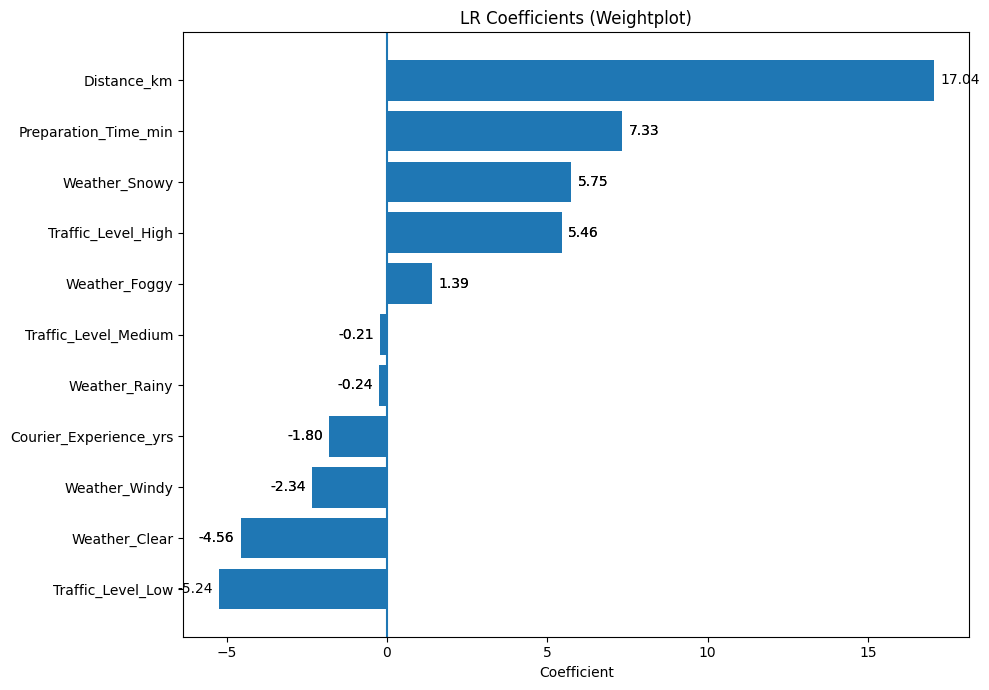

In [ ]:
#Weighted plot
feature_names = X_train.columns.tolist()
coef = pd.Series(lr.coef_, index=feature_names).sort_values()

top_n = 10
coef_plot = pd.concat([coef.head(top_n), coef.tail(top_n)])

plt.figure(figsize=(10,7))
bars = plt.barh(coef_plot.index, coef_plot.values) #barh = bar horizonral
plt.axvline(0) #garis vertikal di angka 0 pada sumbu X

for bar in bars.patches:
    w = bar.get_width()
    y = bar.get_y() + bar.get_height()/2
    if w >= 0:
        plt.text(w + 0.2, y, f"{w:.2f}", va="center")
    else:
        plt.text(w - 0.2, y, f"{w:.2f}", va="center", ha="right")

plt.title("LR Coefficients (Weightplot)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

Model memprediksi waktu pengantaran akan bertambah atau berkurang tergantung kondisi order. Faktor yang paling kuat memperpanjang delivery time adalah jarak (+17,0) dan waktu persiapan (+7,3). Kondisi operasional seperti macet tinggi (+5,4) dan cuaca bersalju (+5,7) juga memberi tambahan menit yang cukup besar. Sebaliknya, pengantaran cenderung lebih cepat saat lalu lintas rendah (−5,2) dan cuaca cerah (−4,5), serta ketika kurir lebih berpengalaman (−1,8).

### **Rekomendasi bisnis**

**1. Program 1: Kurangi jarak pengantaran (prioritas utama)**

Karena jarak (Distance_km) adalah faktor paling besar yang membuat waktu pengantaran lama, perusahaan perlu memastikan pesanan diberikan ke kurir yang paling dekat dan area pengantaran tidak terlalu luas. Tujuannya supaya kurir tidak menempuh perjalanan terlalu jauh. Dampaknya: waktu pengantaran turun dan estimasi waktu (ETA) jadi lebih akurat.

**2. Program 2: Kendalikan waktu persiapan restoran (prioritas kedua)**

Karena waktu persiapan restoran (Preparation_Time_min) sangat berpengaruh, perusahaan perlu memantau restoran mana yang sering lambat dan mana yang cepat. Buat aturan sederhana: restoran yang cepat diberi keuntungan (misalnya prioritas order/bonus), sedangkan restoran yang sering terlambat perlu dibina atau diberi peringatan. Selain itu, kurir sebaiknya dikirim ketika pesanan benar-benar hampir siap, supaya kurir tidak banyak menunggu.

**3. Program 3: Penanganan khusus untuk order yang lama (>71 menit)**

Segmen >71 menit adalah yang paling “berisiko” karena prediksi paling sulit dan potensi komplain lebih tinggi. Karena itu, buat tindakan khusus ketika order mulai mengarah ke lama, misalnya:
- Deteksi dini: sistem menandai order yang diprediksi akan lewat 71 menit.
- Ganti kurir bila perlu (re-assign): jika kurir yang ditugaskan terlalu jauh atau terlambat ambil pesanan, pesanan bisa dialihkan ke kurir yang lebih dekat.
- Batasi batching untuk order berisiko: untuk order yang sudah terlihat akan lama, kurir jangan ditambah tugas mengantar pesanan lain dulu, karena itu akan membuat order makin terlambat.
- Update ETA lebih sering: pelanggan dikabari lebih awal agar ekspektasi lebih realistis dan komplain berkurang.

**4. Program 4: Aturan khusus saat macet atau cuaca buruk**

Walaupun traffic dan cuaca kontribusinya tidak sebesar jarak dan preparation time, kondisi ekstrem tetap bisa menambah menit. Jadi, saat macet parah atau cuaca buruk, perusahaan perlu:
- menambah kurir di area/jam tertentu (agar tidak antre order),
- memperbarui ETA secara otomatis (lebih realistis),
- mengirim notifikasi lebih cepat jika ada potensi keterlambatan.

**5. Program 5: Tambah data operasional agar prediksi keterlambatan ekstrem lebih akurat**

Karena prediksi paling sulit pada order yang lama, perusahaan perlu menambah data yang lebih “nyata” di lapangan, misalnya:
- apakah restoran sedang antre panjang,
- status pesanan sudah “siap diambil” atau belum,
- kurir sedang membawa berapa pesanan sekaligus,
- kondisi traffic berdasarkan rute yang benar-benar dilalui.
Data tambahan ini membantu menurunkan error terutama untuk order >71 menit.

In [ ]:
import joblib


# pastikan scaler yang dipakai ini adalah scaler training yang sama
# scaler sudah fit di df_pretrain[scale_cols] dan transform ke df_test[scale_cols]
# JANGAN bikin scaler baru di sini.

final_features = X_train.columns.tolist()  # kolom final setelah OHE, urutannya penting

artifact = {
    "features": final_features,
    "model": lr,
    "scaler": scaler,          # <--- scaler hasil FIT dari training
    "scale_cols": columns_scale,  # <--- kolom yang harus di-scale
    "iqr": {"q1": 41.0, "q3": 71.0}  # opsional (atau hitung dari y_train)
}

joblib.dump(artifact, "delivery_lr_artifact.pkl")
print("Saved artifact with scaler + features")

Saved artifact with scaler + features


RUMUS SCALLING


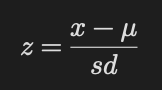

In [65]:
# Membuat tabel

coef_scaled = pd.Series(lr.coef_, index=final_features)
intercept_scaled = float(lr.intercept_)

# Mapping mean & std dari scaler sesuai scale_cols (urutan ini penting)
mu = pd.Series(scaler.mean_, index=columns_scale)
sd = pd.Series(scaler.scale_, index=columns_scale)

# Konversi koefisien numerik: b / sd
coef_unscaled = coef_scaled.copy()
for col in columns_scale:
    if col in coef_unscaled.index:
        coef_unscaled[col] = coef_scaled[col] / sd[col]

# Hitung intercept asli: b0 - sum(b * mu / sd)
intercept_unscaled = intercept_scaled
for col in columns_scale:
    if col in coef_scaled.index:
        intercept_unscaled -= coef_scaled[col] * (mu[col] / sd[col])

print("Intercept (original units):", intercept_unscaled)

# Tabel koefisien versi asli
coef_table = pd.DataFrame({
    "coef_scaled_(per_1SD)": coef_scaled,
    "coef_original_units": coef_unscaled
}).sort_values("coef_original_units", ascending=False)
coef_table.head(15)

Intercept (original units): 15.460228225249178


,coef_scaled_(per_1SD),coef_original_units
Weather_Snowy,5.748618,5.748618
Traffic_Level_High,5.456520,5.456520
Distance_km,17.043634,2.978448
Weather_Foggy,1.391213,1.391213
Preparation_Time_min,7.329256,1.014711
Traffic_Level_Medium,-0.214759,-0.214759
Weather_Rainy,-0.239651,-0.239651
Courier_Experience_yrs,-1.796574,-0.619291
Weather_Windy,-2.341790,-2.341790
Weather_Clear,-4.558389,-4.558389
